In [88]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import warnings
warnings.filterwarnings('ignore')

In [89]:
#import train data
df = pd.read_csv('../input/traindata/train_Df64byy.csv')
df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [90]:
df.info()    # Information about the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

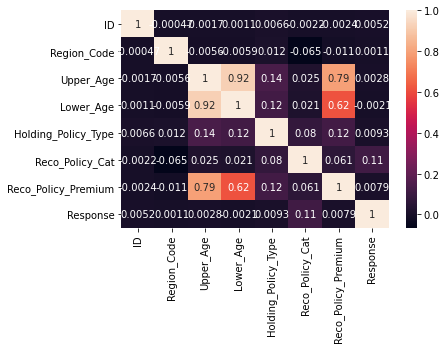

In [91]:
sns.heatmap(df.corr(),annot = True)
plt.show()  # Checking correlation among the numrical data

In [92]:
df = df.drop('Lower_Age',axis = True)  #As Upper_Age and Lower_age have correlation, drop one column

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Is_Spouse                50882 non-null  object 
 7   Health Indicator         39191 non-null  object 
 8   Holding_Policy_Duration  30631 non-null  object 
 9   Holding_Policy_Type      30631 non-null  float64
 10  Reco_Policy_Cat          50882 non-null  int64  
 11  Reco_Policy_Premium      50882 non-null  float64
 12  Response                 50882 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 5.0+ MB


In [94]:
#Both are categorical data in nature
df['Holding_Policy_Type'] = df['Holding_Policy_Type'].astype('object')
df['Reco_Policy_Cat'] = df['Reco_Policy_Cat'].astype('object')

In [123]:
# Differentiate numerical and categorical data
num = df.select_dtypes(include=np.number)
cat = df.select_dtypes(exclude=np.number)

In [124]:
num.isna().sum() # There is no missing values in numerical columns

ID                     0
Region_Code            0
Upper_Age              0
Reco_Policy_Premium    0
Response               0
dtype: int64

In [125]:
# Creating three categories of Upper_Age column. Cause mentioned in Approach
def age_cat(row):
    if row['Upper_Age'] <=30:
        return 1
    elif row['Upper_Age'] > 30 and row['Upper_Age'] <=50:
        return 2
    else:
        return 3

num['Age'] = num.apply(lambda age: age_cat(age),axis=1)
num = num.drop('Upper_Age',axis = 1)

In [126]:
# Dummify the Age Column
num = pd.get_dummies(num,columns = ['Age'],drop_first=True)
num.head()

,ID,Region_Code,Reco_Policy_Premium,Response,Age_2,Age_3
0,1,3213,11628.0,0,1,0
1,2,1117,30510.0,0,0,1
2,3,3732,7450.0,1,1,0
3,4,4378,17780.0,0,0,1
4,5,2190,10404.0,0,1,0


In [127]:
# Checking missing values in Categorical features
cat.isna().sum()

City_Code                      0
Accomodation_Type              0
Reco_Insurance_Type            0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration    20251
Holding_Policy_Type        20251
Reco_Policy_Cat                0
dtype: int64

In [129]:
# Feature Engineering and Data Preprocessing
def cat_data_preprocessing(cat):
    cat['Holding_Policy_Duration'] = cat['Holding_Policy_Duration'].replace('14+','15')
    cat['Health Indicator'] = cat['Health Indicator'].str.replace('X','')
    cat['City_Code'] = cat['City_Code'].str.replace('C','')
    # Impute missing values using KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    a = pd.DataFrame(np.round(imputer.fit_transform(cat[['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']])),columns = ['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type'])
    print('After Imputation , number of null values:',a.isna().sum().sum())
    for i in a.columns:
        cat[i] = a[i]
    # Dummify the categorical features
    cat = pd.get_dummies(cat,columns= cat.columns,drop_first=True,dtype=float)
    return cat

cat = cat_data_preprocessing(cat)
cat.head()

After Imputation , number of null values: 0


,City_Code_10,City_Code_11,City_Code_12,City_Code_13,City_Code_14,City_Code_15,City_Code_16,City_Code_17,City_Code_18,City_Code_19,...,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
# Merging numerical and categorical features and got final dataset
new_df = pd.concat([num,cat],axis=1)
new_df.head()

,ID,Region_Code,Reco_Policy_Premium,Response,Age_2,Age_3,City_Code_10,City_Code_11,City_Code_12,City_Code_13,...,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22
0,1,3213,11628.0,0,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1117,30510.0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,3732,7450.0,1,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,4,4378,17780.0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,5,2190,10404.0,0,1,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [132]:
# Creating Input and Target Features
X = new_df.drop(['Response','ID'],axis = 1)
y = new_df['Response']

In [110]:
# Checking count of records for each category in target variable
df['Response'].value_counts(normalize=True)*100

0    76.005267
1    23.994733
Name: Response, dtype: float64

In [133]:
# As we have less than 25% for category 1, The data is imbalanced. Using OverSampling method to balance the data
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

In [134]:
# Creating train and test data for creating and checking each model results.
Xtrain,Xtest, ytrain, ytest = train_test_split(X, y,test_size = 0.3, random_state = 48)

In [36]:
# Logistic Regression
log = LogisticRegression()
log.fit(Xtrain,ytrain)
y_pred = log.predict(Xtest)
y_prob = log.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

0.5673159800034476
0.583376974715417
[[7265 4500]
 [5540 5899]]


In [37]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(Xtrain,ytrain)
y_pred = dt.predict(Xtest)
y_prob = dt.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

0.8269263920013791
0.8282342075987833
[[ 8649  3116]
 [  900 10539]]


In [38]:
# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(Xtrain,ytrain)
y_pred = rf.predict(Xtest)
y_prob = rf.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

0.8754525081882434
0.9511340722033133
[[ 9850  1915]
 [  975 10464]]


In [39]:
# Extra Tree Classifier
et = ExtraTreeClassifier()
et.fit(Xtrain,ytrain)
y_pred = et.predict(Xtest)
y_prob = et.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

0.8261075676607481
0.8273952371839363
[[ 8656  3109]
 [  926 10513]]


In [40]:
# AdaBoost
ada = AdaBoostClassifier()
ada.fit(Xtrain,ytrain)
y_pred = ada.predict(Xtest)
y_prob = ada.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

0.5827443544216514
0.6196336620564292
[[7133 4632]
 [5050 6389]]


In [41]:
# Gradient Boosting
gd = GradientBoostingClassifier()
gd.fit(Xtrain,ytrain)
y_pred = gd.predict(Xtest)
y_prob = gd.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

0.6044647474573349
0.6527964163427604
[[7545 4220]
 [4958 6481]]


In [42]:
# Extreme Gradient Boosting
xg = XGBClassifier()
xg.fit(Xtrain,ytrain)
y_pred = xg.predict(Xtest)
y_prob = xg.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

[15:57:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.689751766936735
0.7607605403885359
[[7687 4078]
 [3121 8318]]


In [135]:
# LightGBm
lgbm = LGBMClassifier()
lgbm.fit(Xtrain,ytrain)
y_pred = lgbm.predict(Xtest)
y_prob = lgbm.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

0.7591221749099246
0.6640409366461641
[[11439   140]
 [ 3537   149]]


We are getting very good result in Random Forest Classifier and LightGBM. Let's tune it further for better result.

In [ ]:
# Hyperparameter Tuning
rf2 = RandomForestClassifier()


param_dist = { 'n_estimators':sp_randint(50,100),
              'max_features': sp_randint(1,14),
              'max_depth' : sp_randint(5,20),
             'min_samples_leaf':sp_randint(10,50),
              'min_samples_split':sp_randint(2,50)}


rsearch_rf  = RandomizedSearchCV(estimator=rf2, param_distributions = param_dist, cv=4, random_state=4) 

rsearch_rf.fit(X_over,y_over)

In [ ]:
rf_tuned = RandomForestClassifier(**rsearch_rf.best_params_)
rf_tuned.fit(Xtrain,ytrain)
y_pred = rf_tuned.predict(Xtest)
y_prob = rf_tuned.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

In [136]:
# Hyperparameter Tuning
lgbm2 = LGBMClassifier()


param_dist = { 'n_estimators':sp_randint(50,200),
              'learning_rate': sp_uniform(0,0.5),
              'max_depth' : sp_randint(1,15),
             'num_leaves':sp_randint(10,50)}


rsearch_lgbm  = RandomizedSearchCV(estimator=lgbm2, param_distributions = param_dist, cv=4, random_state=4) 

rsearch_lgbm.fit(X,y)
rsearch_lgbm.best_params_

{'learning_rate': 0.11225296186741535,
 'max_depth': 8,
 'n_estimators': 107,
 'num_leaves': 46}

In [137]:
# Best Hyperparameters
rsearch_lgbm.best_params_

{'learning_rate': 0.11225296186741535,
 'max_depth': 8,
 'n_estimators': 107,
 'num_leaves': 46}

In [138]:
# Tuned LightGBM
lgbm_tuned = LGBMClassifier(**rsearch_lgbm.best_params_)
lgbm_tuned.fit(Xtrain,ytrain)
y_pred = lgbm_tuned.predict(Xtest)
y_prob = lgbm_tuned.predict_proba(Xtest)[:,1]
print(accuracy_score(ytest,y_pred))
print(roc_auc_score(ytest,y_prob))
print(confusion_matrix(ytest,y_pred))

0.7602358336062889
0.6676140811356199
[[11361   218]
 [ 3442   244]]


Now check the result in Test Dataset

In [139]:
# importing Test Dataset
test = pd.read_csv('../input/testdata/test_YCcRUnU.csv')
test.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [140]:
test.shape  # Rows and Columns

(21805, 13)

In [141]:
# Same Data Preprocessing for test data also
test = test.drop('Lower_Age',axis=1)
test['Holding_Policy_Type'] = test['Holding_Policy_Type'].astype('object')
test['Reco_Policy_Cat'] = test['Reco_Policy_Cat'].astype('object')

In [142]:
# Differentiate numerical and categorical data
num_test = test.select_dtypes(include=np.number)
cat_test = test.select_dtypes(exclude=np.number)

In [143]:
# No missing values in numerical data
num_test.isna().sum()

ID                     0
Region_Code            0
Upper_Age              0
Reco_Policy_Premium    0
dtype: int64

In [144]:
# creating new column Age using same age_cat function
num_test['Age'] = num_test.apply(lambda age: age_cat(age),axis=1)
num_test = num_test.drop('Upper_Age',axis = 1)

In [145]:
# Dummification 
num_test = pd.get_dummies(num_test,columns = ['Age'],drop_first=True)
num_test.head()

,ID,Region_Code,Reco_Policy_Premium,Age_2,Age_3
0,50883,156,11934.0,0,0
1,50884,7,32204.8,0,1
2,50885,564,9240.0,0,0
3,50886,1177,9086.0,0,0
4,50887,951,22534.0,0,1


In [146]:
# missing values in Categorical data
cat_test.isna().sum()

City_Code                     0
Accomodation_Type             0
Reco_Insurance_Type           0
Is_Spouse                     0
Health Indicator           5027
Holding_Policy_Duration    8603
Holding_Policy_Type        8603
Reco_Policy_Cat               0
dtype: int64

In [147]:
# Data Preprocessing and Feature Engineering for categorical test data
cat_test = cat_data_preprocessing(cat_test)
cat_test.head()

After Imputation , number of null values: 0


,City_Code_10,City_Code_11,City_Code_12,City_Code_13,City_Code_14,City_Code_15,City_Code_16,City_Code_17,City_Code_18,City_Code_19,...,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
# merging numerical and categorical data
new_test = pd.concat([num_test,cat_test],axis=1)
new_test.head()

,ID,Region_Code,Reco_Policy_Premium,Age_2,Age_3,City_Code_10,City_Code_11,City_Code_12,City_Code_13,City_Code_14,...,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22
0,50883,156,11934.0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,50884,7,32204.8,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,50885,564,9240.0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,50886,1177,9086.0,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,50887,951,22534.0,0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
# Drop ID column
new_test = new_test.drop('ID',axis=True)
new_test

,Region_Code,Reco_Policy_Premium,Age_2,Age_3,City_Code_10,City_Code_11,City_Code_12,City_Code_13,City_Code_14,City_Code_15,...,Reco_Policy_Cat_13,Reco_Policy_Cat_14,Reco_Policy_Cat_15,Reco_Policy_Cat_16,Reco_Policy_Cat_17,Reco_Policy_Cat_18,Reco_Policy_Cat_19,Reco_Policy_Cat_20,Reco_Policy_Cat_21,Reco_Policy_Cat_22
0,156,11934.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,32204.8,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,564,9240.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1177,9086.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,951,22534.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21800,1044,15884.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21801,266,21390.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21802,2470,17836.0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21803,1676,11568.0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


We have got best result in tuned random forest but lightGBM is better because it is givng more generalised result.

In [150]:
lgbm_tuned = LGBMClassifier(**rsearch_lgbm.best_params_)
lgbm_tuned.fit(X,y)
y_pred = lgbm_tuned.predict(new_test)
y_prob = lgbm_tuned.predict_proba(new_test)[:,1]

In [156]:
# Submission File
submission = pd.DataFrame(test['ID'], columns = ['ID'])
submission['Response'] = y_prob
submission.head()

,ID,Response
0,50883,0.291494
1,50884,0.374754
2,50885,0.265791
3,50886,0.207643
4,50887,0.217147


In [155]:
submission.to_csv('./Submission3.5(Tuned_LGBM).csv')